**Example of minimiation of ground energy of Hamiltonians**
1. Cooling method
2. Cooling method with SDP

In [1]:
import argparse
import time
import random
import itertools
import numpy as np
import cvxpy as cp
import math
import scipy
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import norm
from qutip import *
from qiskit import *
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Pauli, partial_trace, state_fidelity, random_density_matrix
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector, plot_state_paulivec, plot_state_hinton, plot_state_qsphere
from qiskit.tools.monitor import job_monitor
import os

from SDPforVQE import *
from SDPforVQE import *

In [2]:
def pauli_product(single_pauli_str1, single_pauli_str2):

    if single_pauli_str1 == 'I':
        return [1, single_pauli_str2]
    
    if single_pauli_str2 == 'I':
        return [1, single_pauli_str1]

    
    if single_pauli_str1 == 'X':
        if single_pauli_str2 == 'X':
            return [1, 'I']
        elif single_pauli_str2 == 'Y':
            return [1j, 'Z']
        elif single_pauli_str2 == 'Z':
            return [-1j, 'Y']
        
    if single_pauli_str1 == 'Y':
        if single_pauli_str2 == 'X':
            return [-1j, 'Z']
        elif single_pauli_str2 == 'Y':
            return [1, 'I']
        elif single_pauli_str2 == 'Z':
            return [1j, 'X']
        
    if single_pauli_str1 == 'Z':
        if single_pauli_str2 == 'X':
            return [1j, 'Y']
        elif single_pauli_str2 == 'Y':
            return [-1j, 'X']
        elif single_pauli_str2 == 'Z':
            return [1, 'I']

def pauli_commutator(pauli_str1, pauli_str2):

    commutator = pauliToMatrix(pauli_str1)*pauliToMatrix(pauli_str2) - pauliToMatrix(pauli_str2)*pauliToMatrix(pauli_str1)
    
    if np.all(np.array(commutator) == 0):
        return 0 
    else:
        commutator_str = ''
        coef = 2
        for i in range(len(pauli_str1)):
            result = pauli_product(pauli_str1[i], pauli_str2[i])
            commutator_str = commutator_str + result[1]
            coef = coef*result[0]

    # # Verify
    # if pauliToMatrix(commutator_str)*coef == commutator:
    #     print(True)
    # else:
    #     print(False)
        
        
    return coef, commutator_str

def qiskit_statevec_map(statevec_qiskit, N):
    '''Qiskit orders qubits in a endian way, 
       this function is used to convert a state vector that written in endian ordering to a normal ordering
    '''
    statevec_qiskit = np.array(statevec_qiskit)
    statevec_normal = np.zeros_like(statevec_qiskit, dtype=complex)
    
    for i in range(2**N):
        binary_index = format(i, f'0{N}b')  # Convert the index to an N-bit binary string
        reversed_index = int(binary_index[::-1], 2)  # Reverse the binary string and convert it back to an integer
        
        statevec_normal[reversed_index] = statevec_qiskit[i]

    return Statevector(statevec_normal)

def available_h_set(N, M, K):

    h_set = set({})

    for i in range(N):
        h_set.add('I'*i + 'X' + 'I'*(N-i-1))
        h_set.add('I'*i + 'Y' + 'I'*(N-i-1))
        h_set.add('I'*i + 'Z' + 'I'*(N-i-1))
    
    PauliStrList_part = generate_PauliStrList(M)[1:]
    for k in range(K):
        for basis in PauliStrList_part:
            h_set.add('I'*k + basis + 'I'*(N-k-M))

    return h_set


def find_h_cool(meas_dataset, h_set, H_global_list):
    '''Find all the operators h in h_set such that i<[h,H]> is smaller than 0.
    '''
    
    h_cool = [] # Set of h such that i<[h,H]> is smaller than 0 and the corresponding optimal time t_opt
    for h in h_set:
        
        # Compute [h,H]
        commutator_1st_list = [] # [h,H]
        for H in H_global_list:
            tmp = pauli_commutator(h, H)
            if tmp != 0:
                commutator_1st_list.append(tmp)
        # Get <[h,H]>
        exp_1st = 0+0j
        for commutator in commutator_1st_list:
            exp, var = exp_var_calculator(meas_dataset, commutator[1])
            exp_1st += exp*commutator[0]

        # Compute [h,[h,H]]
        commutator_2nd_list = [] # [h,[h,H]]
        for h_H in commutator_1st_list:
            coef_1st = h_H[0]
            if pauli_commutator(h, h_H[1]) != 0:
                coef_2nd, commutator_2nd = pauli_commutator(h, h_H[1])
                commutator_2nd_list.append( (coef_1st*coef_2nd, commutator_2nd) )
        # Get <[h,[h,H]]>
        exp_2nd = 0+0j
        for commutator in commutator_2nd_list:
            exp, var = exp_var_calculator(meas_dataset, commutator[1])
            exp_2nd += exp*commutator[0]

        if exp_2nd != 0:
            t_opt = exp_1st*1j/exp_2nd
            if t_opt > 0:
                h_cool.append( (h, exp_1st, t_opt, 1j*exp_1st*t_opt) ) # (Pauli string of h, <[h,H]>, t_opt)
 
    return h_cool


In [3]:
def find_h_cool(meas_dataset, h_set, H_global_list):
    '''Find all the operators h in h_set such that i<[h,H]> is smaller than 0.
    '''
    
    h_cool = [] # Set of h such that i<[h,H]> is smaller than 0 and the corresponding optimal time t_opt
    for h in h_set:
        
        # Compute commutator [h,H]
        commutator_1st_list = [] # [h,H]
        for H in H_global_list:
            tmp = pauli_commutator(h, H)
            if tmp != 0:
                commutator_1st_list.append(tmp)
        # Get B = i<[h,H]>
        B_tmp = 0
        for commutator in commutator_1st_list:
            exp, var = exp_var_calculator(meas_dataset, commutator[1])
            B_tmp += exp*commutator[0]
        B = B_tmp*1j

        # Compute commutator [h,[h,H]]
        commutator_2nd_list = [] # [h,[h,H]]
        for h_H in commutator_1st_list:
            coef_1st = h_H[0]
            if pauli_commutator(h, h_H[1]) != 0:
                coef_2nd, commutator_2nd = pauli_commutator(h, h_H[1])
                commutator_2nd_list.append( (coef_1st*coef_2nd, commutator_2nd) )
        # Get A = -1/2*<[h,[h,H]]>
        A_tmp = 0
        for commutator in commutator_2nd_list:
            exp, var = exp_var_calculator(meas_dataset, commutator[1])
            A_tmp += exp*commutator[0]
        A = -1/2*A_tmp

        if A.real != 0 and B.real != 0:
            t_opt = 1/2*math.atan(-B.real/A.real)
            #if t_opt>0:
            decrease = 0.5*(A.real-math.sqrt(A.real**2+B.real**2))
            h_cool.append( (h, B.real, t_opt, decrease) ) # (Pauli string of h, <[h,H]>, t_opt)
 
    return h_cool

In [4]:
def SDP_solver_min_C01(coef:float, 
                   ep:cp.expressions.variable.Variable, ep_C1:cp.expressions.variable.Variable, 
                   dm_tilde:cp.atoms.affine.add_expr.AddExpression, dm_tilde_C1:cp.atoms.affine.add_expr.AddExpression, 
                   H:np.ndarray, 
                   measurement_dataset:Dict[str,List[str]], 
                   N:int, M:int, G:int, K:int, P:int,
                   model_type:str) -> (float,float,float):
    '''Solve the SDP minimization problem with constraints C0 and C0+C1
    '''
    
    dm_tilde_copy01 = dm_tilde

    # Solve SDP with conditions C1+C0
    constraints_0 = constraints_C0(ep, coef, dm_tilde_copy01, measurement_dataset, N, M, K, P, model_type)
    constraints_1 = constraints_C1(ep_C1, coef, dm_tilde_copy01, dm_tilde_C1, measurement_dataset, N, M, G, K, model_type)
    H_exp01 = 0
    for i in range(K):
        H_exp01 = H_exp01 + H @ dm_tilde_copy01[i]
    prob_C01 = cp.Problem(
        cp.Minimize(
            cp.real(
                cp.trace(
                    H_exp01
                )
            )
        ), constraints_0 + constraints_1
    )
    energy_C01 = prob_C01.solve(solver=cp.SCS, verbose=False)
    if prob_C01.status != cp.OPTIMAL:
        energy_C01 = float('inf') 


    return energy_C01


def biSection_search_min_C01(higher_bound:float, threshold:float, 
                         ep:cp.expressions.variable.Variable, ep_C1:cp.expressions.variable.Variable, 
                         dm_tilde:cp.atoms.affine.add_expr.AddExpression, dm_tilde_C1:cp.atoms.affine.add_expr.AddExpression, 
                         H:np.ndarray, 
                         measurement_dataset:Dict[str,List[str]], 
                         N:int, M:int, G:int, K:int, P:int,
                         model_type:str) -> (float,float,float,float):
    '''Use bi-search method to find the minimum value of the relaxation such that there exists at least one solution in the search space,
       with an accuracy of 'threshold'
    '''

    low = 0
    high = higher_bound
    max_iter = 10
   
    energy_C01 = SDP_solver_min_C01(high, ep, ep_C1, dm_tilde, dm_tilde_C1, H, measurement_dataset, N, M, G, K, P, model_type)
    coef = high
    
    # If no solution exists within the initial higher bounds, increase the higher bound.
    while (math.isinf(energy_C01)) and max_iter > 0:
        low = high
        high = 2*high
        max_iter = max_iter-1
        energy_C01 = SDP_solver_min_C01(high, ep, ep_C1, dm_tilde, dm_tilde_C1, H, measurement_dataset, N, M, G, K, P, model_type)

    # If still no solution after expanding the bounds, return an error message.
    if max_iter == 0:
        return "No solution found within the search bounds and maximum iterations."
    
    # Perform the binary search within the updated bounds.
    while abs(high - low) >= threshold:
        coef = low + abs(high - low) / 2
        energy_C01_result = SDP_solver_min_C01(coef, ep, ep_C1, dm_tilde, dm_tilde_C1, H, measurement_dataset, N, M, G, K, P, model_type)
        if (math.isinf(energy_C01_result)):
            low = coef
        else:
            high = coef
            energy_C01 = energy_C01_result

    return energy_C01, coef

In [5]:
model_type = 'open'
N = 5 # Number of qubits of the entire system
M = 2 # Number of qubits of subsystems
G = 3 # Number of qubits of partial global system (C1)

if model_type == 'open':
    K = N-M+1 # Number of subsystems
if model_type == 'closed':
    K = N
P = 4**M-1 # Number of Pauli basis for each subsystem

PauliStrList = generate_PauliStrList(N)[1:]
PauliStrList_part = generate_PauliStrList(M)[1:]
PauliStrList_Gbody = generate_PauliStrList(G)[1:]

h_set = available_h_set(N, M, K)
H_local_list = ['XX','YY'] # Pauli string representation of the local Hamiltonian of subsystems
H_global_list = Hamiltonian_global(H_local_list, N, M, K, model_type) # Pauli string representation of the Hamiltonian of the whole system
H_local_matrix = np.array( Hamiltonian_matrix(H_local_list, model_type) ) # Matrix representation of the local Hamiltonian of subsystems
H_global_matrix = np.array( Hamiltonian_matrix(H_global_list, model_type) ) # Matrix representation of the Hamiltonian of the whole system

ground_state_energy, ground_state_dm = ground_state(H_global_matrix) 
q_state = DensityMatrix(ground_state_dm) # True ground state

higher_bound = 1 # Starting trial value for the bi-search method
threshold = 1 # Accuracy of the minimum relaxation value


In [13]:
N_meas_tol = 1e5 # total number of measurements
N_opt = 20 # number of iterations of cooling
N_meas = int(N_meas_tol/N_opt) # number of measurements in all basis each loop

# Initialize states 
tmp = np.zeros(2**N)
tmp[0] = 1
input_state = DensityMatrix( qiskit_statevec_map( Statevector(tmp), N ) ) # |000> state
#exp_H_old = 100

exp_H_list = [] # expectation value of H as a function of iterations
exp_SDP_list = {}
exp_SDP_list['C01'] = []
exp_SDP_list['coef'] = []

for i in tqdm(range(N_opt)):
    meas_dataset = generate_meas_dataset(input_state, N_meas, N)
   
    # Get the expectation value <H>
    exp_H_new = 0
    for H in H_global_list:
        exp, var = exp_var_calculator(meas_dataset, H)
        exp_H_new += exp

    #if exp_H_new < exp_H_old:
    exp_H_list.append(exp_H_new)
    #exp_H_old = exp_H_new

    # Select the best h (the one such that e^(-iht) gives the most decrease in <H>)
    h_cool = find_h_cool(meas_dataset, h_set, H_global_list) # Get the set of h that can induce a cooling unitary
    h_best, B, t_opt, decrease = max(h_cool, key=lambda x: abs(x[3])) 
    
    # Get the Qiskit circuit of e^(-iht)
    circ_meas = QuantumCircuit(N) 
    if (B < 0 and t_opt < 0):
        U = Operator( scipy.linalg.expm( -1j * (t_opt+math.pi/2) * np.array(pauliToMatrix(h_best)) ) )
    elif (B < 0 and t_opt > 0):
        U = Operator( scipy.linalg.expm( -1j * t_opt * np.array(pauliToMatrix(h_best)) ) )
    elif (B > 0 and t_opt < 0):
        U = Operator( scipy.linalg.expm( 1j * (-t_opt) * np.array(pauliToMatrix(h_best)) ) )
    elif (B > 0 and t_opt > 0):
        U = Operator( scipy.linalg.expm( 1j * (-t_opt+math.pi/2) * np.array(pauliToMatrix(h_best)) ) )

    register = list(range(N))
    tmp = input_state
    input_state = tmp.evolve(U, register[::-1])

    # Solve the SDP problem to get a lower estimate on gs energy 
    ep = cp.Variable((K, P))
    if model_type=='open':
        K_3body = N-G+1 # Number of 3-body subsystems
    if model_type=='closed':
        K_3body = K # Number of 3-body subsystems
    ep_C1 = cp.Variable((K_3body, 4**G-1))

    dm_tilde, dm_hat = SDP_variables_C0(ep, meas_dataset, N, M, K, P, PauliStrList_part, model_type)
    dm_tilde_C1 = SDP_variables_C1(ep_C1, meas_dataset, N, G, K, PauliStrList_Gbody, model_type)

    # Energy with SDP - minimum
    E_min_C01_value, coef_min_value = biSection_search_min_C01(higher_bound, threshold, 
                                                                            ep, ep_C1, dm_tilde, dm_tilde_C1, 
                                                                            H_local_matrix, meas_dataset, 
                                                                            N, M, G, K, P,
                                                                            model_type
                                                                            )

    exp_SDP_list['C01'].append(E_min_C01_value)
    exp_SDP_list['coef'].append(coef_min_value)


100%|██████████| 20/20 [07:15<00:00, 21.79s/it]


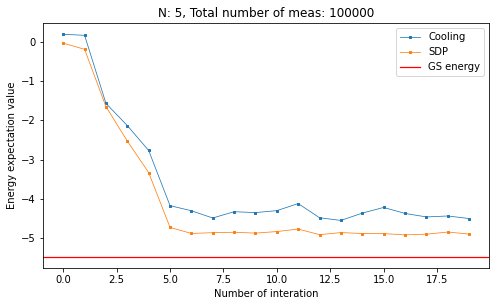

In [14]:
plt.figure(figsize=(8, 4.5))

plt.plot(exp_H_list, linewidth=0.75, marker='s', markersize=2.5, label='Cooling')
plt.plot(exp_SDP_list['C01'], linewidth=0.75, marker='s', markersize=2.5, label='SDP')
plt.axhline(y = ground_state_energy, color='r', linestyle='-', linewidth=1.25, label='GS energy')

titlename = 'N: ' + str(N) + ', Total number of meas: ' + str(int(N_meas_tol))
plt.title(titlename)
plt.xlabel('Number of interation')
plt.ylabel('Energy expectation value')
plt.legend()

figurename = model_type + '_N' + str(N) + '_opt' + '.pdf'
figurepath = f'figures/{figurename}'
#plt.savefig(figurepath, bbox_inches='tight')
plt.show()

In [256]:
exp_SDP_list['coef']

[0.25,
 0.25,
 1.25,
 2.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25]

In [286]:
# Definition for a binary tree node.
class TreeNode:
    def __init__(self, val=0, left=None, right=None):
        self.val = val
        self.left = left
        self.right = right



In [298]:
root = TreeNode(1)
root.left = TreeNode(2, TreeNode(4), TreeNode(5))
root.right = TreeNode(3)

print(root)

In [302]:
a = [0,0,0,0,0]
a[0:0]

[]